In [50]:
from sklearn.datasets import make_circles
X,y = make_circles(noise=0.03, n_samples=1500, random_state=35)
for i in range(0,5):
    print(f"X is: {X[i]}, y is: {y[i]}")

X is: [-0.65161214  0.49322017], y is: 1
X is: [0.55904871 0.62309637], y is: 1
X is: [ 0.2228903  -0.97649012], y is: 0
X is: [0.47841954 0.6406794 ], y is: 1
X is: [-0.09171774  0.8654792 ], y is: 1


In [51]:
import pandas as pd
dataset = pd.DataFrame({
    'X1' : X[ : , 0],
    'X2' : X[ : , 1],
    'target' : y
})

dataset.head(n=10)

,X1,X2,target
0,-0.651612,0.493220,1
1,0.559049,0.623096,1
2,0.222890,-0.976490,0
3,0.478420,0.640679,1
4,-0.091718,0.865479,1
5,-0.664013,0.716876,0
6,-0.633620,-0.478248,1
7,-0.257723,0.865155,0
8,0.179108,0.812150,1
9,0.139748,-0.782155,1


In [52]:
dataset.shape

(1500, 3)

In [53]:
print(dataset[dataset['target']==0].count())
print(dataset[dataset['target']==1].count())

X1        750
X2        750
target    750
dtype: int64
X1        750
X2        750
target    750
dtype: int64


In [54]:
print(dataset.iloc[ : , 0])

0      -0.651612
1       0.559049
2       0.222890
3       0.478420
4      -0.091718
          ...   
1495   -0.152567
1496   -0.451498
1497   -0.668218
1498   -0.106616
1499   -0.120854
Name: X1, Length: 1500, dtype: float64


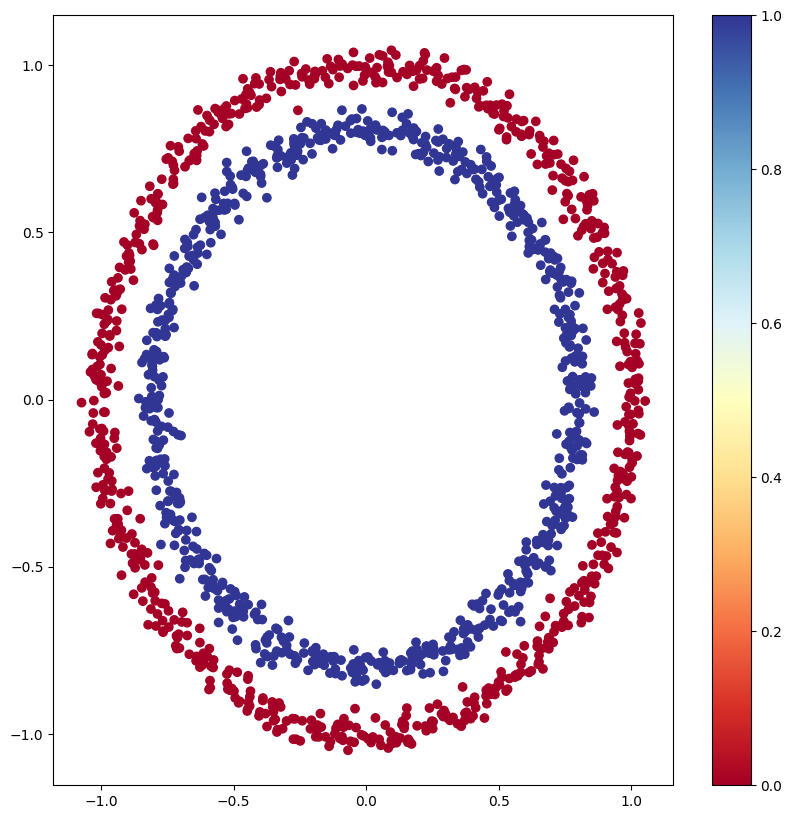

In [55]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.scatter(x=dataset.iloc[:, 0], 
            y=dataset.iloc[:, 1], 
            c=dataset.iloc[:, 2], 
            cmap=plt.cm.RdYlBu)

plt.colorbar()  # Add color bar to show mapping of color to values
plt.show()


In [56]:
X,Y= dataset.iloc[ : , 0:2], dataset.iloc[ : ,2]
print(X.shape)
print(Y.shape)

(1500, 2)
(1500,)


In [57]:
import torch
from  sklearn.model_selection import train_test_split

In [58]:
X = torch.from_numpy(X.values).type(torch.float32)
Y = torch.from_numpy(Y.values).type(torch.float32)
print(X)
print(Y)

tensor([[-0.6516,  0.4932],
        [ 0.5590,  0.6231],
        [ 0.2229, -0.9765],
        ...,
        [-0.6682,  0.4291],
        [-0.1066,  0.8205],
        [-0.1209, -0.7690]])
tensor([1., 1., 0.,  ..., 1., 1., 1.])


In [59]:
print(X.ndim)
print(X.shape)

2
torch.Size([1500, 2])


In [60]:
print(Y.ndim)
print(Y.shape)

1
torch.Size([1500])


In [61]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [62]:
print(X_train.ndim)
print(X_train.shape)
print(X_test.ndim)
print(X_test.shape)

2
torch.Size([1200, 2])
2
torch.Size([300, 2])


In [63]:
print(Y_train.ndim)
print(Y_train.shape)
print(Y_test.ndim)
print(Y_test.shape)

1
torch.Size([1200])
1
torch.Size([300])


In [64]:
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [65]:
X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)


In [66]:
class CircleClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_one=torch.nn.Linear(in_features=2, out_features=10)
        self.layer_two=torch.nn.Linear(in_features=10, out_features=10)
        self.layer_three=torch.nn.Linear(in_features=10, out_features=1)
        self.relu=torch.nn.ReLU()

    def forward(self, X):
        return self.layer_three(self.relu(self.layer_two(self.relu(self.layer_one(X)))))
        #return self.layer_two(self.layer_one(X))



In [67]:
model_cc =CircleClassification()
loss_func=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(model_cc.parameters(), lr=0.01)

In [68]:
def calc_accuracy(y_test, y_pred):
    correct=torch.eq(y_test, y_pred).sum().item()
    return correct/len(y_pred)*100

In [69]:
#testing model 
model_cc.eval()
with torch.inference_mode():
    preds = model_cc(X_test[0:5, : ]).squeeze()
    logits = torch.sigmoid(preds)
    rounded = torch.round(logits)


for i in range(5):
    print(f"Input: {X_test[i]}, Actual: {Y_test[i]}, Val: {preds[i]}, Logit: {logits[i]}, Prediction: {rounded[i]}")

Input: tensor([-0.1696,  0.8252]), Actual: 1.0, Val: -0.02329888939857483, Logit: 0.494175523519516, Prediction: 0.0
Input: tensor([-0.1191,  0.7904]), Actual: 1.0, Val: -0.023109465837478638, Logit: 0.49422287940979004, Prediction: 0.0
Input: tensor([-0.9333, -0.4158]), Actual: 0.0, Val: 0.0006305426359176636, Logit: 0.5001576542854309, Prediction: 1.0
Input: tensor([-1.0172,  0.2580]), Actual: 0.0, Val: -0.024516507983207703, Logit: 0.49387121200561523, Prediction: 0.0
Input: tensor([-0.7860, -0.0242]), Actual: 1.0, Val: -0.014630630612373352, Logit: 0.49634242057800293, Prediction: 0.0


In [70]:
epochs = 1000

epoch_count=[]
train_loss_vals = []
test_loss_vals = []

for epoch in range(epochs):
    model_cc.train()
    optimizer.zero_grad()
    prediction=model_cc(X_train).squeeze()
    loss_train=loss_func(Y_train, prediction)
    logits=torch.round(torch.sigmoid(prediction))
    train_acc=calc_accuracy(Y_train, logits)
    loss_train.backward()
    optimizer.step()

    model_cc.eval()
    with torch.inference_mode():
        preds = (model_cc(X_test)).squeeze()
        loss_test = loss_func(preds, Y_test)
        ylogits=torch.round(torch.sigmoid(preds))
        test_acc = calc_accuracy(Y_test,preds)
        if epoch%100 == 0 or epoch == 999:
            epoch_count.append(epoch)
            train_loss_vals.append(loss_train)
            test_loss_vals.append(loss_test)
            print(f"Epoch: {epoch}, Train_Loss: {loss_train:.5f}, Train_acc: {train_acc:.2f}%, Test_Loss: {loss_test:.5f}, Test_acc: {test_acc:.2f}%")
        



Epoch: 0, Train_Loss: 1.00630, Train_acc: 49.67%, Test_Loss: 0.69742, Test_acc: 46.33%
Epoch: 100, Train_Loss: 0.23545, Train_acc: 50.75%, Test_Loss: 1.03398, Test_acc: 47.00%
Epoch: 200, Train_Loss: -3.51750, Train_acc: 50.75%, Test_Loss: 4.93106, Test_acc: 47.00%
Epoch: 300, Train_Loss: -3017.34790, Train_acc: 50.75%, Test_Loss: 4095.42798, Test_acc: 47.00%
Epoch: 400, Train_Loss: nan, Train_acc: 0.00%, Test_Loss: nan, Test_acc: 0.00%
Epoch: 500, Train_Loss: nan, Train_acc: 0.00%, Test_Loss: nan, Test_acc: 0.00%
Epoch: 600, Train_Loss: nan, Train_acc: 0.00%, Test_Loss: nan, Test_acc: 0.00%
Epoch: 700, Train_Loss: nan, Train_acc: 0.00%, Test_Loss: nan, Test_acc: 0.00%
Epoch: 800, Train_Loss: nan, Train_acc: 0.00%, Test_Loss: nan, Test_acc: 0.00%
Epoch: 900, Train_Loss: nan, Train_acc: 0.00%, Test_Loss: nan, Test_acc: 0.00%
Epoch: 999, Train_Loss: nan, Train_acc: 0.00%, Test_Loss: nan, Test_acc: 0.00%


In [71]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)



helper_functions.py already exists, skipping download


torch.Size([10201, 2])
torch.Size([10201, 1])
torch.Size([10201, 2])
torch.Size([10201, 1])


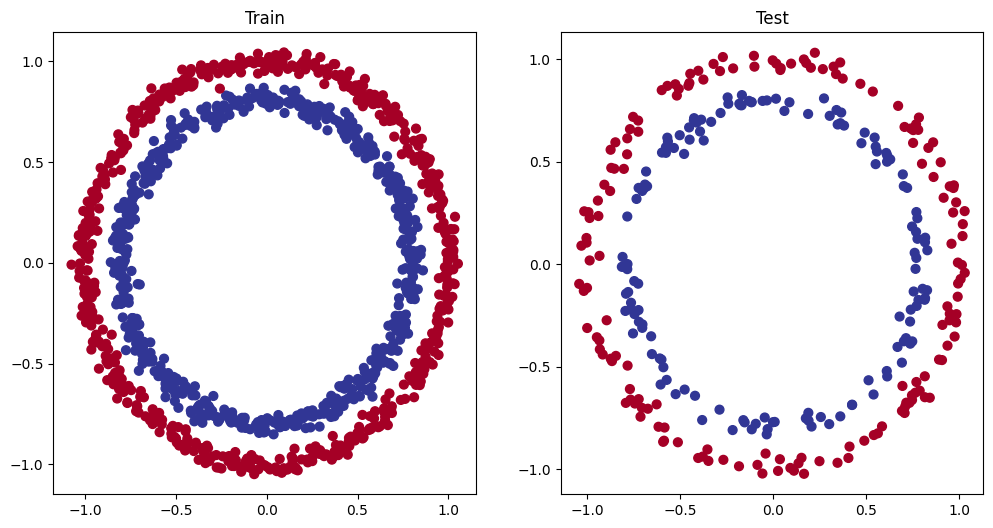

In [72]:
# Plot decision boundaries for training and test sets
from helper_functions import plot_predictions, plot_decision_boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_cc, X_train, Y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_cc, X_test, Y_test)